In [163]:
import numpy as np
import torch
from torch import nn
import torch.functional as F
import torchvision
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms,utils, models
import matplotlib.pyplot as plt
import torch.nn.functional as F
from collections import OrderedDict
from PIL import Image

In [164]:
test=[]
test2=[]
for i in range(1000):
    test.append(np.random.randint(2))
    test2.append(np.random.randint(0,1))


In [165]:
np.mean(test)

0.518

In [166]:
np.mean(test2)

0.0

In [167]:


class att_dataset(Dataset):
    
    def __init__(self,main_dir,data_transorm):
        
        self.train_dir=main_dir+'train/'
        self.test_dir=main_dir+'test/'
        self.data_transform=data_transorm

        #self.trainset = datasets.ImageFolder(self.train_dir, transform=data_transform)
        self.trainset = datasets.ImageFolder(self.train_dir)
        self.len=len(list(self.trainset.imgs))   #self.trainset.imgs gives tuples
        #testset = datasets.ImageFolder(self.test_dir, transform=data_transform)

                      
    def __getitem__(self,index):
        
        self.indx1 = np.random.choice(len(self.trainset.imgs))
        self.img1=self.trainset.imgs[self.indx1]  #tuple first image
        
        
        #make 50% 
        
        self.random_gen=np.random.randint(2)
        
        while True:   
        
            index2 = np.random.choice(len(self.trainset.imgs))
            img2=self.trainset.imgs[index2]
        
            if ((self.img1[1]==img2[1]) and (self.random_gen==1)):   #label checking
                self.indx2=index2
                self.img2=img2
                
                break
                
            if ((self.img1[1]!=img2[1]) and (self.random_gen==0)):   #label checking
                self.indx2=index2
                self.img2=img2

                break    
                
        img0_ = Image.open(self.img1[0])
        img1_ = Image.open(self.img2[0])
        
        img0_ = self.data_transform(img0_)
        img1_ = self.data_transform(img1_)
                
                
        return img0_,img1_,torch.from_numpy(np.array([self.random_gen]))
    
    def __len__(self):
                       
        return self.len
    
    

                                                
                                                
# TODO: Using the image datasets and the trainforms, define the dataloaders


#test_loader = torch.utils.data.DataLoader(testset, batch_size=64,shuffle=True)     

In [183]:
main_dir='att_faces/'
train_dir=main_dir+'train/'
test_dir=main_dir+'test/'

data_transform = transforms.Compose([transforms.Resize(112),
        transforms.CenterCrop(105),
        transforms.ToTensor()]) #,transforms.Normalize((0.5,), (0.5,))
dataset_att=att_dataset(main_dir='att_faces/',data_transorm=data_transform)
train_loader = torch.utils.data.DataLoader(dataset_att, batch_size=8,shuffle=True)

In [184]:
example_batch = next(iter(train_loader))

In [185]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

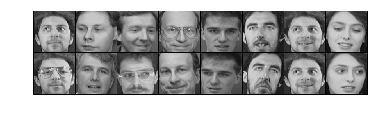

[[1]
 [0]
 [0]
 [1]
 [1]
 [1]
 [1]
 [1]]


In [199]:
example_batch = next(iter(train_loader))
concatenated = torch.cat((example_batch[0],example_batch[1]),0)
imshow(torchvision.utils.make_grid(concatenated))
print(example_batch[2].numpy())
#plt.imshow(example_batch[0])

In [45]:
np.random.randint(2, size=(10,2))

array([[1, 1],
       [0, 0],
       [1, 0],
       [0, 1],
       [0, 1],
       [0, 0],
       [1, 0],
       [0, 1],
       [1, 0],
       [1, 0]])

torch.Size([64, 3, 105, 105])
torch.Size([64])


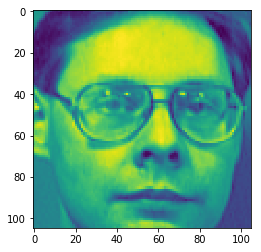

In [46]:
image,label=next(iter(train_loader))
print(image.size())
print(label.size())
for i in range(5):
    
    plt.imshow(image[i][0,:])
    plt.show

In [4]:
class simese_network(nn.Module):
    def __init__(self):
        super(simese_network,self).__init__()
        
        self.conv1=nn.Conv2d(1,64,kernel_size=10)   # (105-10-0)/1 +1=96     96*96*64 
        self.relu1=nn.ReLU()                        #                        96*96*64
        self.maxpool1=nn.MaxPool2d(kernel_size=2)   #                        48*48 *64
        self.batchnorm1=nn.BatchNorm2d(64)
        self.dropout1=nn.Dropout2d(p=0.2)
        
        self.conv2=nn.Conv2d(64,128,kernel_size=7)  #  (48-7-0)/1+1= 42     42*42*128
        self.relu2=nn.ReLU()                        #                       42*42*128
        self.maxpool2=nn.MaxPool2d(kernel_size=2)   #                       21*21*128
        self.batchnorm2=nn.BatchNorm2d(128)
        self.dropout2=nn.Dropout2d(p=0.2)
        
        self.conv3=nn.Conv2d(128,128,kernel_size=4) # (21-4-0)/1+1= 18     18*18*128
        self.relu3=nn.ReLU()                        #                      18*18*128
        self.maxpool3=nn.MaxPool2d(kernel_size=2)   #                      9*9*128
        self.batchnorm3=nn.BatchNorm2d(128)
        self.dropout3=nn.Dropout2d(p=0.2)
        
        self.conv4=nn.Conv2d(128,256,kernel_size=4) # (9-4-0)/1+1=6       6*6*256 
        self.relu4=nn.ReLU() 
        self.batchnorm4=nn.BatchNorm2d(256)
        self.dropout4=nn.Dropout2d(p=0.2)
        
        self.linear1=nn.Linear(9216,4096)
        self.relu5=nn.ReLU()
        
        self.linear2=nn.Linear(4096,512)
        self.relu6=nn.ReLU()
        
        self.linear3=nn.Linear(512,10)
        self.relu7=nn.ReLU()   
        
        self.linear4=nn.Linear(10,5)       
        
        
        

    def forward_main(self,x):
        
        in_channel_batch=x.size(0)
        
        x=self.dropout1(self.batchnorm1(self.maxpool1(self.relu1(self.conv1(x)))))
              
        x=self.dropout2(self.batchnorm2(self.maxpool2(self.relu2(self.conv2(x)))))
        
        x=self.dropout3(self.batchnorm3(self.maxpool3(self.relu3(self.conv3(x)))))
        
        x=self.dropout4(self.batchnorm4(self.relu4(self.conv4(x))))
        
        x=x.view(in_channel_batch,-1)  #batch batch size* -1
        
        
        x=self.relu5(self.linear1(x))
        x=self.relu6(self.linear2(x))        
        x=self.relu7(self.linear3(x))
        
        x=self.linear4(x)
        
        output=x
        
        return output
    
    
    def forward_twin(self,x1,x2):
        
        output1=forward_main(x1)
        output2=forward_main(x2)
        
        return output1,output2
        
    
    
    

In [5]:

class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive
